# Notebook containing code to produce the figures and stats in the paper

This notebook contains code to produce the replication sample for the paper supplement. Basically every plot and statistic in the main text is rerun with the replication sample.

- Figure 2: Encoding performance
    - Fig 2A: points by index relative to boundary
    - Fig 2B: rt by index relative to boundary
    - Fig 2C: post-error slowing by index relative to boundary

- Figure 3: Recall performance
    - Fig 3A: Serial position curve
    - Fig 3B: CRP

- Figure 4: Evidence for boundary effects
    - Fig 4A: recall by boundary label

- Figure 5: Boundarys/events organize recall
    - Fig 5A: Event CRP
    - Fig 5B: Probability of transitioning to new event (steppingstone)
    - Fig 5C: Clustering using ARC

- Figure 6: RL model
    - Fig 6A: RPE by trial number in encoding task
    - Fig 6B: RPE to memory predictions


Running this notebook will regenerate the figures and stats in the main text of the paper.



## Setup

The following blocks load some libraries and set some parameters for the remainder of the notebook.

They also load the data from the experiment and the model fits to generate the figures and stats.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import seaborn as sns
import pingouin as pg
from psifr import fr
import sys

sys.path.append("../../")
from pymer4 import Lmer, Lm

sns.set_theme(style="white", context="paper")
from itertools import combinations
from src.data.process_strat import *


red = "#e41a1c"
green = "#4daf4a"
blue = "#377eb8"

# make a palette for incorrect and correct
pal = [red, blue, green]

In [2]:
strat_df = pd.read_csv(
    "../../data/processed/exp2/check/DecayFeatureRL_strat_data_rpe.csv"
)
rl_df = pd.read_csv(
    "../../data/processed/exp2/check/DecayFeatureRL_no_resp_st_results.csv"
)
fr_df = pd.read_csv("../../data/interim/exp2/mem_df.csv")
strat_df.subid.nunique()

strat_df = strat_df[strat_df["condition"] == 1].reset_index(drop=True)
strat_df["prev_points"] = strat_df.groupby(["subid", "run"])["points"].shift(1)

In [3]:
# get rid of people with fewer than 15 words recalled
fr_df = fr_df.dropna(subset=["word"])
fr_df["subid"] = fr_df["subject"]
fr_df["recalled"] = fr_df["recall"] & fr_df["study"]
recalls = fr_df.groupby(["subject", "list"])["recalled"].sum()

# Find subjects with less than 5 recalls per list
bad_subs = set(recalls[recalls < 1].reset_index()["subject"])
print(len(bad_subs))
fr_df = fr_df[~fr_df["subject"].isin(bad_subs)]
strat_df = strat_df[~strat_df["subid"].isin(bad_subs)]
rl_df = rl_df[~rl_df["subid"].isin(bad_subs)]
strat_df["word"] = strat_df["word"].str.lower()

0


In [4]:
with open("../../data/processed/exp2/strat_subs.txt", "w") as f:
    for sub in strat_df.subid.unique().tolist():
        f.write(sub + "\n")

In [5]:
strat_df = strat_df.merge(
    rl_df[
        [
            "subid",
            "eta",
        ]
    ],
    on="subid",
)
strat_df.head()
strat_df.subid.nunique()

139

In [6]:
fr_df = fr_df.merge(
    strat_df[
        [
            "subid",
            "word",
            "rpe",
            "uncertainty",
            "trial_within_block",
            "correct_rule",
            "disc",
            "item_rule",
            "within_across",
            "eta",
        ]
    ],
    on=["subid", "word"],
    how="left",
)

boundary_labels = {0: "Boundary", 1: "Post-Boundary", -1: "Pre-Boundary"}
fr_df["boundary_label"] = fr_df["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)

In [7]:
fr_df = fr_df[fr_df["subid"].isin(strat_df["subid"])].reset_index(drop=True)

## Overlap between subjective event boundaries and changes in latent state

In [8]:
strat_df["marker_match"] = strat_df[["rel_subj_boundary", "trial_within_block"]].apply(
    lambda x: x[0] == x[1], axis=1
)
only_bounds = strat_df[strat_df["rel_subj_boundary"] == 0]
only_bounds.groupby(["subid"])["marker_match"].mean().describe()
ob_gb = only_bounds.groupby(["subid"])["marker_match"].mean()
print(
    f"Overlap between boundary markers is mean = {np.round(ob_gb.mean(),3)}, std = {np.round(ob_gb.std(),3)}"
)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/3893441887.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: x[0] == x[1], axis=1


Overlap between boundary markers is mean = 0.791, std = 0.118


## Figure 2: Rule shifts reliably induce event boundaries

In [9]:
model = Lmer(
    "points ~ rel_subj_boundary*run + (1|subid)", data=strat_df, family="binomial"
)
model.fit()

/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "within_across". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'str'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: points~rel_subj_boundary*run+(1|subid)

Family: binomial	 Inference: parametric

Number of observations: 31136	 Groups: {'subid': 139.0}

Log-likelihood: -20396.555 	 AIC: 40803.111

Random effects:

              Name    Var    Std
subid  (Intercept)  0.069  0.263

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.375,0.303,0.447,0.037,1.455,1.354,1.564,0.593,0.575,0.610,10.200,0.000,***
rel_subj_boundary,-0.088,-0.111,-0.065,0.012,0.916,0.895,0.937,0.478,0.472,0.484,-7.591,0.000,***
run,0.062,0.041,0.083,0.011,1.064,1.042,1.086,0.515,0.510,0.521,5.744,0.000,***
rel_subj_boundary:run,0.008,0.000,0.017,0.004,1.008,1.000,1.017,0.502,0.500,0.504,2.026,0.043,*


In [10]:
# does current rpe on trial_t predict rt_z_score on next trial?
subset_df = strat_df.copy()
subset_df = subset_df[~subset_df["rt"].isna()].reset_index(drop=True)

fitting_boundary_labels = {0: "2Boundary", 1: "Post-Boundary", -1: "Pre-Boundary"}
subset_df["boundary_label"] = subset_df["rel_subj_boundary"].apply(
    lambda x: (
        fitting_boundary_labels[x] if x in fitting_boundary_labels else "1Non-Boundary"
    )
)
subset_df["boundary_label"] = subset_df["boundary_label"].astype("category")
subset_df["inv_points"] = 1 - subset_df["points"]
subset_df["prev_inv_points"] = subset_df.groupby(["subid", "run"])["inv_points"].shift(
    1
)
subset_df = subset_df[subset_df["rt"] > 0]
subset_df["rt_log"] = np.log(subset_df["rt"])
subset_df = subset_df.dropna(
    subset=["rt_log", "trial_within_block", "boundary_label", "prev_inv_points"]
)


model = Lmer(
    "rt_log~ C(boundary_label)+prev_inv_points+trial_within_block + (1|subid) + (1|word)",
    data=subset_df[
        [
            "rt_log",
            "trial_within_block",
            "boundary_label",
            "prev_inv_points",
            "subid",
            "word",
        ]
    ],
    family="gaussian",
)
model.fit()

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_log~C(boundary_label)+prev_inv_points+trial_within_block+(1|subid)+(1|word)

Family: gaussian	 Inference: parametric

Number of observations: 29857	 Groups: {'word': 432.0, 'subid': 139.0}

Log-likelihood: -16536.179 	 AIC: 33090.359

Random effects:

                 Name    Var    Std
word      (Intercept)  0.003  0.054
subid     (Intercept)  0.039  0.198
Residual               0.172  0.415

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.084,7.048,7.120,0.018,188.180,387.172,0.000,***
C(boundary_label)2Boundary,-0.031,-0.049,-0.014,0.009,29617.171,-3.458,0.001,***
C(boundary_label)Post-Boundary,0.030,0.012,0.047,0.009,29567.401,3.319,0.001,***
C(boundary_label)Pre-Boundary,-0.010,-0.025,0.005,0.008,29597.180,-1.277,0.202,
prev_inv_points,0.069,0.058,0.081,0.006,29605.687,11.742,0.000,***
trial_within_block,-0.006,-0.009,-0.003,0.002,29605.214,-3.728,0.000,***


/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/2008948447.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), fontsize=12)
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/2008948447.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels(g.get_yticklabels(), fontsize=12)
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/2008948447.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), fontsize=12)
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/2008948447.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator

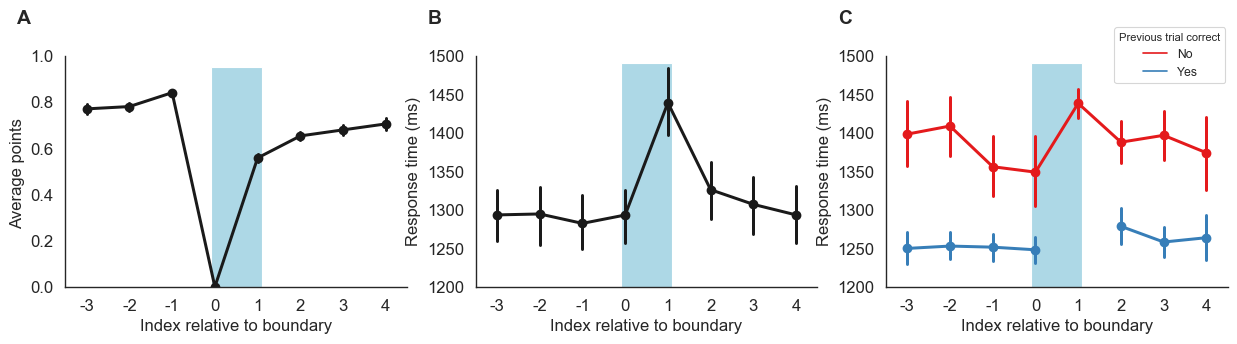

In [11]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 3, wspace=0.2)

fig = plt.figure(figsize=(15, 3))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
gb_df = (
    strat_df.groupby(["subid", "rel_subj_boundary"])[["points", "rt"]]
    .mean()
    .reset_index()
)
g = sns.pointplot(
    data=gb_df[gb_df["rel_subj_boundary"].isin(range(-3, 5))],
    y="points",
    ax=ax1,
    x="rel_subj_boundary",
    color="k",
)
g.set_ylabel("Average points ", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle((2.9, 0), 1.2, 0.95, facecolor="#ADD8E6", edgecolor=None, zorder=0)
)
g.set_ylim(0, 1)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)

# B
ax2 = plt.subplot(gs[1])
g = sns.pointplot(
    data=gb_df[gb_df["rel_subj_boundary"].isin(range(-3, 5))],
    y="rt",
    ax=ax2,
    x="rel_subj_boundary",
    color="k",
)
g.set_ylabel("Response time (ms)", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle((2.9, 1), 1.2, 1490, facecolor="#ADD8E6", edgecolor=None, zorder=0)
)
g.set_ylim(1200, 1500)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)
sns.despine()

# C
ax3 = plt.subplot(gs[2])
# g= sns.pointplot(data=subset_df,x='trial_within_block',y='rt',hue='prev_points',errorbar='ci',palette=pal,ax=ax3,
#  linestyles=['--','-'])
g = sns.pointplot(
    data=strat_df[strat_df["rel_subj_boundary"].isin(range(-3, 5))],
    x="rel_subj_boundary",
    y="rt",
    palette=pal,
    errorbar="ci",
    ax=ax3,
    hue="prev_points",
)
# g= sns.pointplot(data=subset_df[(subset_df['rel_subj_boundary'].isin(range(1,5))) & (subset_df['prev_points']==1)],x='rel_subj_boundary',y='rt',errorbar='ci',palette=[pal[1]],ax=ax3,hue='prev_points')
# # remove legend
# g= sns.pointplot(data=subset_df[(subset_df['rel_subj_boundary'].isin(range(-3,1))) & (subset_df['prev_points']==1)],x='rel_subj_boundary',y='rt',errorbar='ci',palette=[pal[1]],ax=ax3,hue='prev_points')
g.legend_.remove()

# remove legend
g.set_ylabel("Response time (ms)", fontsize=12)
g.set_xlabel("Index relative to boundary", fontsize=12)
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)
# g.axvline(1,linestyle='--')
g.set_ylim(1200, 1500)
g.add_patch(plt.Rectangle((2.9, 1), 1.2, 1490, facecolor="#ADD8E6", zorder=0))
# g.add_patch(plt.Rectangle((3.8, 0), 1100, 1420, fill=None, edgecolor='grey', lw=2))
sns.despine()
# add a legend to C
legend_handles = [
    mlines.Line2D([], [], color=pal[0], linestyle="-", label="No"),
    mlines.Line2D([], [], color=pal[1], linestyle="-", label="Yes"),
]
# ax2.set_ylabel('Predicted probability of recall success',fontsize=10)
plt.legend(
    handles=legend_handles,
    title="Previous trial correct",
    bbox_to_anchor=(0.65, 1.15),
    title_fontsize="small",
)

sub_fig_labels = [(ax1, "A"), (ax2, "B"), (ax3, "C")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.2,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

fig.savefig(
    "../../results/figs/replication/encoding_perf.png", bbox_inches="tight", dpi=350
)

# Figure 3: General recall characteristics

In [12]:
recalls = (fr_df.groupby(["subject"])["recalled"].sum() / 224).reset_index()
recalls["recalled"].describe()
print(f'Average proportion recalled is {np.round(recalls["recalled"].mean(),3)}')
print(f'Std of proportion recalled is {np.round(recalls["recalled"].std(),3)}')

Average proportion recalled is 0.182
Std of proportion recalled is 0.082


In [13]:
# plot setup
recall = fr.spc(fr_df)
lag_crp = fr.lag_crp(fr_df)
max_lag = 8
pos_lag_crp = lag_crp.query(f"0 < lag <= {max_lag}")
neg_lag_crp = lag_crp.query(f"{-max_lag} <= lag < 0")

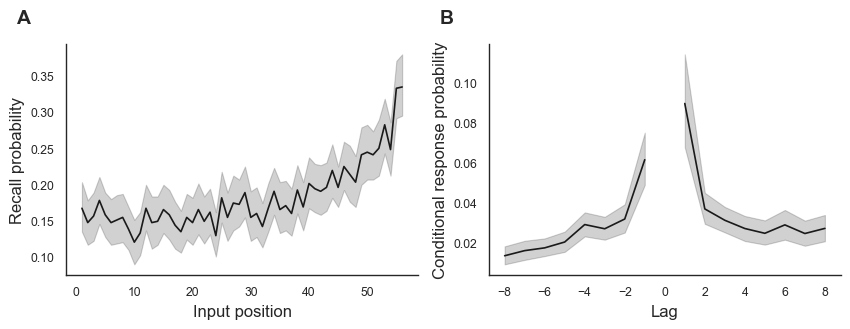

In [14]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 2, wspace=0.2)

fig = plt.figure(figsize=(10, 3))
sns.despine()


# A
ax1 = plt.subplot(gs[0])
g = sns.lineplot(data=recall, x="input", y="recall", color="k", ax=ax1)
# g.set_xlabel('Run')
g.set_ylabel("Recall probability", fontsize=12)
g.set_xlabel("Input position", fontsize=12)
sns.despine()

# B
ax2 = plt.subplot(gs[1])
gpos = sns.lineplot(data=pos_lag_crp, x="lag", y="prob", ax=ax2, color="k")
gneg = sns.lineplot(data=neg_lag_crp, x="lag", y="prob", ax=ax2, color="k")
ax2.set_ylabel("Conditional response probability", fontsize=12)
ax2.set_xlabel("Lag", fontsize=12)
sns.despine()

# # C
# ax3 = plt.subplot(gs[2])
# sns.regplot(data=fr_df[fr_df['cumulative_points'].isin(range(8))],x='cumulative_points', y='recalled',logistic=True,scatter=False,color='k',ax=ax3)
# sns.despine()
# ax3.set_xlabel('Run length of correct points',fontsize=12)
# ax3.set_ylabel('Predicted probability of recall',fontsize=12)


sub_fig_labels = [(ax1, "A"), (ax2, "B")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.15,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

fig.savefig(
    "../../results/figs/replication/recall_perf.png", bbox_inches="tight", dpi=350
)

In [15]:
pg.ttest(
    pos_lag_crp.query("lag==1")["prob"],
    neg_lag_crp.query("lag==-1")["prob"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.266455,138,two-sided,0.024979,"[0.0035814309410731743, 0.052563157058521125]",0.237806,1.119,0.795079


In [59]:
# Fig 3A: recall proportion by points
# fr2 = fr_df[~fr_df['rel_subj_boundary'].isin([1])]
gb_df = fr_df.groupby(["subject", "points"])["recalled"].mean().reset_index()
# remove the within subject mean from both points
sub_means = fr_df.groupby("subject")["recalled"].mean()
gb_df = gb_df.merge(sub_means, on="subject", suffixes=("", "_mean"))

gb_df["recalled_minus_within"] = gb_df["recalled"] - gb_df["recalled_mean"]
# add back the grand_mean
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
# gb_df

In [17]:
pg.ttest(
    gb_df.query("points == 0")["recalled"],
    gb_df.query("points == 1")["recalled"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-3.032551,138,two-sided,0.002898,"[-0.021463741435503853, -0.0045210019167522385]",0.154358,7.431,0.439371


# Figure 4: Effects of event boundaries on recall

In [18]:
blues = sns.color_palette("Blues", 6)
blues = blues[2:]

In [19]:
blues[0] = (0.5, 0.5, 0.5)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/3901445830.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.swarmplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/3901445830.py:23: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/3901445830.py:23: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/3901445830.py:39: UserWarning: set_ticklabels() should only be used with a fixed numb

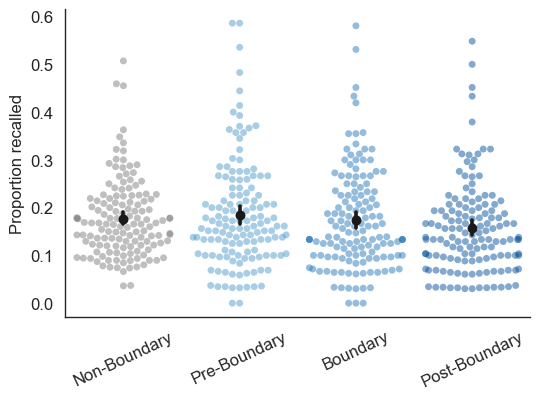

In [20]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 1, wspace=0.2)
fontsize = 12
fig = plt.figure(figsize=(6, 4))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
gb_df = fr_df.groupby(["subject", "boundary_label"])["recalled"].mean().reset_index()

g = sns.swarmplot(
    data=gb_df,
    x="boundary_label",
    y="recalled",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    palette=blues,
    alpha=0.5,
    # errorbar="ci",
    # scale=1.2,
)

# ax1.set_title('Response time changes by boundary position and reward')
g = sns.pointplot(
    data=gb_df,
    x="boundary_label",
    y="recalled",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    # palette=blues,
    color="k",
    join=False,
    # alpha = 0.5
    errorbar="ci",
    scale=1.2,
    ax=ax1,
    zorder=10,
)
ax1.set_ylabel("Proportion recalled", fontsize=fontsize)
ax1.set_xlabel("")
ax1.set_xticklabels(
    ["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    rotation=25,
    fontsize=fontsize,
)
ax1.set_yticklabels(np.round(ax1.get_yticks(), 2), fontsize=fontsize)
sns.despine()


# g.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Rewarded at encoding')
# # change the legend labels from 0.0 and 1.0 to No and Yes
# new_labels = ['No', 'Yes']
# for t, l in zip(g.legend_.texts, new_labels): t.set_text(l)


# sub_fig_labels=[(ax2,"A"),(ax1,"B")]
# for ax, label in sub_fig_labels:
#     ax.text(-0.1, 1.15, label, transform=ax.transAxes,
#             fontsize=14, fontweight='bold', va='top', ha='right')
#
fig.savefig(
    "../../results/figs/replication/main_result.png", bbox_inches="tight", dpi=350
)

In [21]:
# pg.pairwise_tests(
#     dv="recalled",
#     within="boundary_label",
#     subject="subject",
#     data=gb_df,
#     effsize="cohen",
#     parametric=True,
# )

uniq_boundary_labels = gb_df["boundary_label"].unique()
# Create an empty list to store results
results = []

# Perform all pairwise comparisons
for i in range(len(uniq_boundary_labels)):
    for j in range(i + 1, len(uniq_boundary_labels)):
        # Filter data for each condition
        group1 = gb_df[gb_df["boundary_label"] == uniq_boundary_labels[i]]["recalled"]
        group2 = gb_df[gb_df["boundary_label"] == uniq_boundary_labels[j]]["recalled"]

        # Perform t-test with confidence intervals
        ttest_result = pg.ttest(group1, group2, paired=True, confidence=0.95)

        # Add condition labels
        ttest_result["A"] = uniq_boundary_labels[i]
        ttest_result["B"] = uniq_boundary_labels[j]

        # Append to results
        results.append(ttest_result)

# Combine all results
all_results = pd.concat(results, ignore_index=True)
all_results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,A,B
0,-0.638901,138,two-sided,0.523946,"[-0.01564499523416979, 0.0080036924670668]",0.041067,0.115,0.076878,Boundary,Non-Boundary
1,1.988078,138,two-sided,0.048782,"[8.422195676551956e-05, 0.030996161389384415]",0.156424,0.638,0.448916,Boundary,Post-Boundary
2,-1.541518,138,two-sided,0.125481,"[-0.026929790805520087, 0.003335096628769858]",0.109500,0.3,0.249494,Boundary,Pre-Boundary
3,3.134907,138,two-sided,0.002101,"[0.007149231012432646, 0.031572455100820275]",0.220021,9.928,0.731042,Non-Boundary,Post-Boundary
4,-1.257997,138,two-sided,0.210517,"[-0.020514364844634914, 0.00456097343498767]",0.081921,0.204,0.160208,Non-Boundary,Pre-Boundary
5,-3.275500,138,two-sided,0.001334,"[-0.04384024558260488, -0.010834831940295291]",0.264339,14.985,0.871768,Post-Boundary,Pre-Boundary


The above table contains all the pairwise tests for figure 4.

# Figure 5: Boundaries and events structure recall

In [25]:
# Defining a function to get the probability of a word transitioning to a boundary word


def get_stepping_stone(sub_df):
    """
    Calculates the probability that a given word between shifts is a boundary word
    """
    # now let's get all the recalled words
    recalled = sub_df[sub_df["recall"] & sub_df["study"]]
    recalled = recalled.sort_values(by=["output"]).reset_index(drop=True)
    # now within recalled, let's get the words that were recalled after a block shift
    recalled["block_shift"] = recalled["block"] != recalled["block"].shift(1)

    # now grab all the words that were recalled after a block shift and count them up by rel_subj_boundary
    return recalled[recalled["block_shift"]]["rel_subj_boundary"].value_counts(
        normalize=True
    )


# now let's apply this function to each subject and each list
stepping_stone = (
    fr_df.groupby(["subid", "list"]).apply(get_stepping_stone).reset_index()
)
stepping_stone.rename(
    columns={"proportion": "prob_position"},
    inplace=True,
)
# stepping_stone
stepping_stone = (
    stepping_stone.groupby(["subid", "rel_subj_boundary"])["prob_position"]
    .mean()
    .reset_index()
)
stepping_stone['boundary_label'] = stepping_stone['rel_subj_boundary'].apply(lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary")
# stepping_stone = stepping_stone[stepping_stone['rel_subj_boundary'].isin(range(-4,5))].reset_index(drop=True)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/3651781394.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fr_df.groupby(["subid", "list"]).apply(get_stepping_stone).reset_index()


In [26]:
gb_df = (
    stepping_stone.groupby(["subid", "boundary_label"])["prob_position"]
    .mean()
    .reset_index()
)

In [28]:
bad_subs = gb_df.groupby(["subid"])["boundary_label"].count().reset_index()
bad_subs = bad_subs.loc[bad_subs["boundary_label"] < 4, "subid"].values

In [29]:
# Create an empty list to store results
results = []
gb_df = gb_df[~gb_df["subid"].isin(bad_subs)].reset_index()
uniq_boundary_labels = gb_df["boundary_label"].unique()

# Perform all pairwise comparisons
for i in range(len(uniq_boundary_labels)):
    for j in range(i + 1, len(uniq_boundary_labels)):
        # Filter data for each condition
        group1 = gb_df[gb_df["boundary_label"] == uniq_boundary_labels[i]][
            "prob_position"
        ]
        group2 = gb_df[gb_df["boundary_label"] == uniq_boundary_labels[j]][
            "prob_position"
        ]

        # Perform t-test with confidence intervals
        ttest_result = pg.ttest(group1, group2, paired=True, confidence=0.95)

        # Add condition labels
        ttest_result["A"] = uniq_boundary_labels[i]
        ttest_result["B"] = uniq_boundary_labels[j]

        # Append to results
        results.append(ttest_result)

# Combine all results
all_results = pd.concat(results, ignore_index=True)
all_results

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,A,B
0,4.400064,126,two-sided,0.000023,"[0.019137439411748097, 0.05042283248050025]",0.482442,669.728,0.999704,Boundary,Non-Boundary
1,1.799586,126,two-sided,0.074319,"[-0.0018548107297228361, 0.0390697985149978]",0.216801,0.472,0.678898,Boundary,Post-Boundary
2,1.152401,126,two-sided,0.251338,"[-0.006884731798625297, 0.02608207192868892]",0.126917,0.188,0.294761,Boundary,Pre-Boundary
3,-2.416667,126,two-sided,0.017096,"[-0.029416164876154824, -0.0029291192308185383]",0.211361,1.613,0.656814,Non-Boundary,Post-Boundary
4,-3.386869,126,two-sided,0.000944,"[-0.03989516971486994, -0.010467762047314763]",0.388174,21.312,0.991366,Non-Boundary,Pre-Boundary
5,-0.934178,126,two-sided,0.351999,"[-0.02809319346828458, 0.010075545813073235]",0.112809,0.151,0.243117,Post-Boundary,Pre-Boundary


In [30]:
all_results.loc[1, "CI95%"][0]

np.float64(-0.0018548107297228361)

### Event based clustering

In [31]:
# get the clustering arc scores for each subject and label them by the block or correct rule
block_clust = fr.category_clustering(fr_df, category_key="block")
block_clust["category"] = "block"
cr_clust = fr.category_clustering(fr_df, category_key="item_rule")
cr_clust["category"] = "item_rule"

fr_df_no_post = fr_df[~fr_df["rel_subj_boundary"].isin([1])].reset_index(drop=True)
block_clust_no_post = fr.category_clustering(fr_df_no_post, category_key="block")
block_clust_no_post["category"] = "block_no_post"
cr_clust_no_post = fr.category_clustering(fr_df_no_post, category_key="item_rule")
cr_clust_no_post["category"] = "item_rule_no_post"


block_clust_no_post = block_clust_no_post.dropna(subset="arc")
cr_clust_no_post = cr_clust_no_post.dropna(subset="arc")

event_crp = fr.lag_crp(fr_df, lag_key="block")
event_crp

/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/psifr/fr.py:1770: RuntimeWarning: Mean of empty slice
  clust = pd.Series({'lbc': np.nanmean(lbc), 'arc': np.nanmean(arc)})


,subject,lag,prob,actual,possible
0,5617da425c62cf00118231b8,-31.0,NaN,0,0
1,5617da425c62cf00118231b8,-30.0,NaN,0,0
2,5617da425c62cf00118231b8,-29.0,NaN,0,0
3,5617da425c62cf00118231b8,-28.0,NaN,0,0
4,5617da425c62cf00118231b8,-27.0,NaN,0,0
...,...,...,...,...,...
8752,67240ea419a9065a4284a609,27.0,NaN,0,0
8753,67240ea419a9065a4284a609,28.0,NaN,0,0
8754,67240ea419a9065a4284a609,29.0,NaN,0,0
8755,67240ea419a9065a4284a609,30.0,NaN,0,0


In [32]:
pg.ttest(
    event_crp.query("lag==1")["prob"], event_crp.query("lag==-1")["prob"], paired=True
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.791599,138,two-sided,0.000223,"[0.0028077588670063634, 0.008927809831784277]",0.464368,77.34,0.999746


In [33]:
event_crp = event_crp.dropna(subset="prob")
event_crp["forward_backward"] = event_crp["lag"].apply(
    lambda x: x if x in [-1, 0, 1] else "backward" if np.sign(x) == -1 else "forward"
)
forback_df = (
    event_crp[event_crp["lag"].isin(range(-8, 8))]
    .groupby(["subject", "forward_backward"])["prob"]
    .mean()
    .reset_index()
)
pg.ttest(
    forback_df[forback_df["forward_backward"] == "backward"]["prob"],
    forback_df[forback_df["forward_backward"] == "forward"]["prob"],
    paired=True,
)

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/2309423487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_crp["forward_backward"] = event_crp["lag"].apply(


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.704898,138,two-sided,8.620748e-15,"[-0.012699336420551672, -0.007997975330447996]",1.07206,7.488e+11,1.0


In [34]:
pg.ttest(
    block_clust_no_post["arc"],
    block_clust.loc[block_clust["subject"].isin(block_clust_no_post["subject"]), "arc"],
    paired=True,
)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.049644,138,two-sided,0.960478,"[-0.04018106484646218, 0.0382128350894946]",0.003036,0.095,0.050145


In [58]:
points_clust = fr.category_clustering(fr_df, category_key="points")
points_clust["category"] = "points"
# points_clust["arc"].mean()
label_clust = fr.category_clustering(fr_df, category_key="rel_subj_boundary")
label_clust["category"] = "label"
# label_clust["arc"].mean()

In [36]:
# combine all the "clust" dataframes
clust_df = pd.concat([block_clust, cr_clust, points_clust, label_clust])
clust_df = clust_df.dropna(subset=["arc"])
Greys = sns.color_palette("Greys", 6)
Greys = Greys[2:]

In [37]:
clust_df = clust_df.merge(
    rl_df[["subid", "eta"]], left_on="subject", right_on="subid", how="left"
)

In [38]:
# do the pairwise comparisons of each clustering type in cluster df
print(
    pg.pairwise_tests(
        data=clust_df, dv="arc", within="category", subject="subject", effsize="cohen"
    )
)
print("\n")

print("\ntests against 0")
print("\n")
print(pg.ttest(clust_df.query('category=="block"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="item_rule"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="points"')["arc"], 0))
print("\n")
print(pg.ttest(clust_df.query('category=="label"')["arc"], 0))

   Contrast          A          B  Paired  Parametric         T    dof  \
0  category      block  item_rule    True        True  1.569594  138.0   
1  category      block      label    True        True  3.603455  138.0   
2  category      block     points    True        True  2.802166  138.0   
3  category  item_rule      label    True        True  2.297717  138.0   
4  category  item_rule     points    True        True  0.970751  138.0   
5  category      label     points    True        True -1.028031  138.0   

  alternative     p-unc    BF10     cohen  
0   two-sided  0.118800   0.312  0.189974  
1   two-sided  0.000437  41.544  0.461892  
2   two-sided  0.005807   3.993  0.307553  
3   two-sided  0.023082   1.197  0.271837  
4   two-sided  0.333371    0.15  0.129930  
5   two-sided  0.305734   0.158 -0.122737  



tests against 0


               T  dof alternative     p-val  \
T-test  4.947406  138   two-sided  0.000002   

                                             CI95%   cohe

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/1111518628.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.swarmplot(
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 28.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 18.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.wa

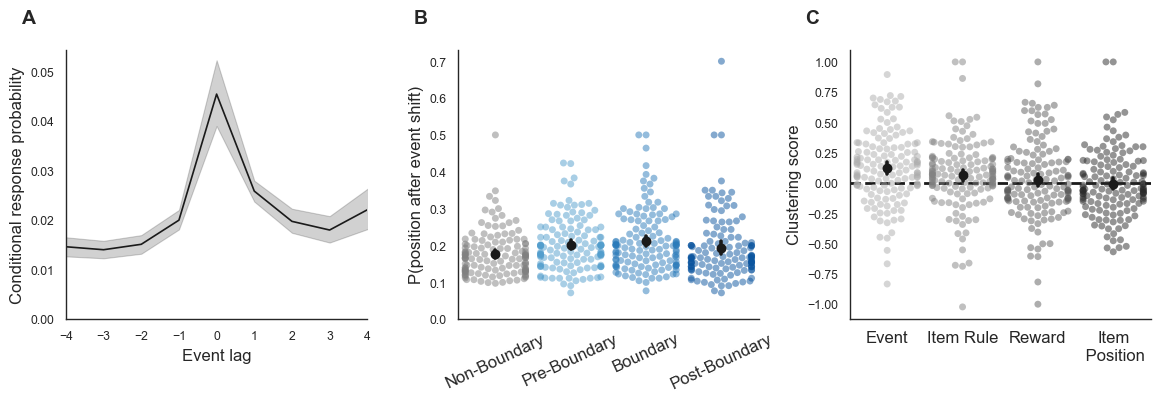

In [39]:
# # Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(1, 3, wspace=0.3)

fig = plt.figure(figsize=(14, 3.5))
sns.despine()

# A
ax1 = plt.subplot(gs[0])
max_lag = 4
event_crp = fr.lag_crp(fr_df, lag_key="block")

sns.lineplot(data=event_crp, x="lag", y="prob", color="k", ax=ax1)
ax1.set_ylabel("Conditional response probability", fontsize=12)
ax1.set_xlabel("Event lag", fontsize=12)
ax1.set_xlim(-max_lag, max_lag)
sns.despine()


# B
ax2 = plt.subplot(gs[1])

# sns.lineplot(data=neg_event_crp,x='lag',y='prob',color='k')

stepping_stone["boundary_label"] = stepping_stone["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)
gb_df = (
    stepping_stone.groupby(["subid", "boundary_label"])["prob_position"]
    .mean()
    .reset_index()
)
gb_df = gb_df.pivot(
    index="subid", columns="boundary_label", values="prob_position"
).reset_index()
gb_df = gb_df.fillna(0)
gb_df = gb_df.melt(id_vars="subid", value_name="prob_position")
sub_means = gb_df.groupby("subid")["prob_position"].mean().reset_index()
gb_df = gb_df.merge(sub_means, on="subid", suffixes=("", "_mean"))
gb_df["recalled_minus_within"] = gb_df["prob_position"] - gb_df["prob_position_mean"]
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
g = sns.swarmplot(
    data=gb_df[~gb_df["subid"].isin(bad_subs)].reset_index(drop=True),
    x="boundary_label",
    y="prob_position",
    palette=blues,
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    alpha=0.5,
    ax=ax2,
)
g = sns.pointplot(
    data=gb_df[~gb_df["subid"].isin(bad_subs)].reset_index(drop=True),
    x="boundary_label",
    y="prob_position",
    # palette=blues,
    color="k",
    order=["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    errorbar="ci",
    scale=1.2,
    join=False,
    ax=ax2,
    zorder=10,
)
g.set_ylabel("P(position after event shift)", fontsize=12)
g.set_xlabel("")
g.set_xticklabels(
    ["Non-Boundary", "Pre-Boundary", "Boundary", "Post-Boundary"],
    rotation=25,
    fontsize=12,
)
sns.despine()


# C
ax3 = plt.subplot(gs[2])
# plot the clustering arc scores
sub_means = clust_df.groupby("subject")["arc"].mean().reset_index()
gb_df = clust_df.merge(sub_means, on="subject", suffixes=("", "_mean"))
gb_df["recalled_minus_within"] = gb_df["arc"] - gb_df["arc_mean"]
gb_df["recalled_plus_grand_mean"] = (
    gb_df["recalled_minus_within"] + fr_df.recalled.mean()
)
g = sns.swarmplot(data=gb_df, x="category", y="arc", palette=Greys, alpha=0.5, ax=ax3)
g = sns.pointplot(
    data=gb_df,
    x="category",
    y="arc",
    color="k",
    scale=1.2,
    errorbar="ci",
    ax=ax3,
    join=False,
    zorder=10,
)
g.set_ylabel("Clustering score", fontsize=12)
g.set_xlabel("")
# g.set_title('Clustering of recall by task features')
g.axhline(0.0, color="k", linestyle="--", linewidth=2)
g.set_xticklabels(["Event", "Item Rule", "Reward", "Item\n Position"], fontsize=12)
sns.despine()

sub_fig_labels = [(ax1, "A"), (ax2, "B"), (ax3, "C")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.1,
        1.15,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )

ax1.set_ylim(0, ax1.get_ylim()[1])
ax2.set_ylim(0, ax2.get_ylim()[1])


# fig.savefig("../../results/figs/recall_seq_fig.pdf", bbox_inches="tight", dpi=350)
fig.savefig(
    "../../results/figs/replication/recall_seq_fig.png", bbox_inches="tight", dpi=350
)

# Figure 6: RL model predicts recall

Using a logistic regression model, we can predict the probability of recalling an item given the boundary label of the item and the boundary label of the previous item.

In [40]:
subset_df = (
    strat_df.groupby(["subid", "trial_within_block"])["trial_by_trial_loglik"]
    .mean()
    .reset_index()
)
subset_df["trial_by_trial_lik"] = np.exp(subset_df["trial_by_trial_loglik"])
rpe_df = strat_df.groupby(["subid", "rel_subj_boundary"])["rpe"].mean().reset_index()

In [41]:
log_reg_df = fr_df[
    [
        "subid",
        "word",
        "rpe",
        "recall",
        "study",
        "points",
        "rel_subj_boundary",
        "run",
        "trial_within_block",
        "boundary_label",
        "uncertainty",
    ]
]
log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)
log_reg_df = log_reg_df.dropna()
log_reg_df["abs_rpe"] = np.abs(log_reg_df["rpe"])
log_reg_df["val_rpe"] = np.sign(log_reg_df["rpe"])
log_reg_df["mean_cent_abs_rpe"] = log_reg_df["abs_rpe"] - log_reg_df["abs_rpe"].mean()
log_reg_df["mean_cent_uncertainty"] = (
    log_reg_df["uncertainty"] - log_reg_df["uncertainty"].mean()
)
# log_reg_df = log_reg_df[log_reg_df['rel_subj_boundary'].isin(range(-3,5))].reset_index(drop=True)
model = Lmer(
    "recall_success ~ mean_cent_abs_rpe * val_rpe + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model.fit()

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/3749896224.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/3749896224.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_abs_rpe*val_rpe+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 31668	 Groups: {'word': 432.0, 'subid': 139.0}

Log-likelihood: -14123.125 	 AIC: 28258.250

Random effects:

              Name    Var    Std
word   (Intercept)  0.203  0.450
subid  (Intercept)  0.259  0.509

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.675,-1.775,-1.574,0.051,0.187,0.169,0.207,0.158,0.145,0.172,-32.693,0.000,***
mean_cent_abs_rpe,-0.033,-0.120,0.053,0.044,0.967,0.887,1.055,0.492,0.470,0.513,-0.754,0.451,
val_rpe,-0.025,-0.056,0.006,0.016,0.976,0.946,1.006,0.494,0.486,0.502,-1.555,0.120,
mean_cent_abs_rpe:val_rpe,-0.105,-0.193,-0.016,0.045,0.901,0.824,0.984,0.474,0.452,0.496,-2.315,0.021,*


In [42]:
model = Lmer(
    "recall_success ~ mean_cent_abs_rpe * val_rpe + mean_cent_uncertainty + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model.fit()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_abs_rpe*val_rpe+mean_cent_uncertainty+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 31668	 Groups: {'word': 432.0, 'subid': 139.0}

Log-likelihood: -14109.767 	 AIC: 28233.535

Random effects:

              Name    Var    Std
word   (Intercept)  0.203  0.450
subid  (Intercept)  0.258  0.508

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.672,-1.772,-1.572,0.051,0.188,0.170,0.208,0.158,0.145,0.172,-32.695,0.000,***
mean_cent_abs_rpe,-0.008,-0.095,0.079,0.045,0.992,0.909,1.083,0.498,0.476,0.520,-0.178,0.859,
val_rpe,-0.043,-0.075,-0.011,0.016,0.958,0.928,0.989,0.489,0.481,0.497,-2.655,0.008,**
mean_cent_uncertainty,4.374,2.732,6.016,0.838,79.342,15.363,409.760,0.988,0.939,0.998,5.221,0.000,***
mean_cent_abs_rpe:val_rpe,-0.122,-0.211,-0.033,0.045,0.885,0.809,0.967,0.469,0.447,0.492,-2.694,0.007,**


In [43]:
log_reg_df = fr_df[
    [
        "subid",
        "word",
        "rpe",
        "uncertainty",
        "recall",
        "study",
        "points",
        "rel_subj_boundary",
        "run",
        "trial_within_block",
        "boundary_label",
    ]
]
log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)
log_reg_df = log_reg_df.dropna()
log_reg_df["abs_rpe"] = np.abs(log_reg_df["rpe"])
log_reg_df["val_rpe"] = np.sign(log_reg_df["rpe"])
log_reg_df["mean_cent_abs_rpe"] = log_reg_df["abs_rpe"] - log_reg_df["abs_rpe"].mean()
# log_reg_df = log_reg_df[log_reg_df['rel_subj_boundary'].isin(range(-3,5))].reset_index(drop=True)
model = Lmer(
    "recall_success ~ uncertainty + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model.fit()

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/565134953.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/565134953.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~uncertainty+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 31668	 Groups: {'word': 432.0, 'subid': 139.0}

Log-likelihood: -14117.130 	 AIC: 28242.259

Random effects:

              Name    Var    Std
word   (Intercept)  0.203  0.450
subid  (Intercept)  0.258  0.508

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.816,-1.930,-1.701,0.058,0.163,0.145,0.182,0.140,0.127,0.154,-31.145,0.0,***
uncertainty,3.840,2.238,5.441,0.817,46.505,9.375,230.678,0.979,0.904,0.996,4.699,0.0,***


In [44]:
strat_df.groupby("subid")[["rpe", "uncertainty"]].corr(method="spearman")

rpe  uncertainty
subid                                                      
5617da425c62cf00118231b8 rpe          1.000000     0.267639
                         uncertainty  0.267639     1.000000
58a1fe40ea3d11000170d9b9 rpe          1.000000     0.158035
                         uncertainty  0.158035     1.000000
594a969df0ea1b0001558178 rpe          1.000000     0.062301
...                                        ...          ...
67239f4f85318190f3ee173a uncertainty  0.194116     1.000000
6723e1f006b4c75bc2b1f43c rpe          1.000000     0.191682
                         uncertainty  0.191682     1.000000
67240ea419a9065a4284a609 rpe          1.000000    -0.200257
                         uncertainty -0.200257     1.000000

[278 rows x 2 columns]

In [45]:
strat_df["boundary_label"] = strat_df["rel_subj_boundary"].apply(
    lambda x: boundary_labels[x] if x in boundary_labels else "Non-Boundary"
)
rt_df = strat_df.groupby(["subid", "boundary_label"])["rt"].mean().reset_index()
rt_df = rt_df.pivot(index="subid", columns="boundary_label", values="rt").reset_index()
clust_df = clust_df.merge(rt_df, on="subid", suffixes=("", "_rt"))
clust_df["diff_rt"] = clust_df["Post-Boundary"] - clust_df["Boundary"]

In [52]:
log_reg_df = fr_df[
    [
        "subid",
        "word",
        "rpe",
        "uncertainty",
        "recall",
        "study",
        "points",
        "rel_subj_boundary",
        "run",
        "trial_within_block",
        "boundary_label",
        # "rt",
    ]
]
log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)
log_reg_df = log_reg_df.dropna()
log_reg_df["abs_rpe"] = np.abs(log_reg_df["rpe"])
log_reg_df["val_rpe"] = np.sign(log_reg_df["rpe"])
log_reg_df["mean_cent_abs_rpe"] = log_reg_df["abs_rpe"] - log_reg_df["abs_rpe"].mean()
log_reg_df["mean_cent_certainty"] = (
    log_reg_df["uncertainty"] - log_reg_df["uncertainty"].mean()
)
# log_reg_df = log_reg_df[log_reg_df['rel_subj_boundary'].isin(range(-3,5))].reset_index(drop=True)
model1 = Lmer(
    "recall_success ~ mean_cent_certainty + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model1.fit()

/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/875992999.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall"] & log_reg_df["study"]
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/875992999.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_reg_df["recall_success"] = log_reg_df["recall_success"].astype(int)


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_certainty+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 31668	 Groups: {'word': 432.0, 'subid': 139.0}

Log-likelihood: -14117.130 	 AIC: 28242.259

Random effects:

              Name    Var    Std
word   (Intercept)  0.203  0.451
subid  (Intercept)  0.258  0.508

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.687,-1.787,-1.587,0.051,0.185,0.168,0.205,0.156,0.143,0.170,-33.06,0.0,***
mean_cent_certainty,3.840,2.239,5.441,0.817,46.505,9.380,230.576,0.979,0.904,0.996,4.70,0.0,***


In [53]:
log_reg_df["mean_cent_certainty"] = (
    log_reg_df["uncertainty"] - log_reg_df["uncertainty"].mean()
)
model2 = Lmer(
    "recall_success ~ mean_cent_certainty + (mean_cent_abs_rpe*val_rpe) + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model2.fit()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_certainty+(mean_cent_abs_rpe*val_rpe)+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 31668	 Groups: {'word': 432.0, 'subid': 139.0}

Log-likelihood: -14109.767 	 AIC: 28233.535

Random effects:

              Name    Var    Std
word   (Intercept)  0.203  0.450
subid  (Intercept)  0.258  0.508

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.672,-1.772,-1.572,0.051,0.188,0.170,0.208,0.158,0.145,0.172,-32.697,0.000,***
mean_cent_certainty,4.374,2.744,6.003,0.831,79.341,15.555,404.702,0.988,0.940,0.998,5.261,0.000,***
mean_cent_abs_rpe,-0.008,-0.095,0.079,0.045,0.992,0.909,1.083,0.498,0.476,0.520,-0.178,0.859,
val_rpe,-0.043,-0.075,-0.011,0.016,0.958,0.928,0.989,0.489,0.481,0.497,-2.656,0.008,**
mean_cent_abs_rpe:val_rpe,-0.122,-0.211,-0.033,0.045,0.885,0.809,0.967,0.469,0.447,0.492,-2.694,0.007,**


In [54]:
log_reg_df["mean_cent_certainty"] = (
    log_reg_df["uncertainty"] - log_reg_df["uncertainty"].mean()
)
model3 = Lmer(
    "recall_success ~ mean_cent_abs_rpe*val_rpe + (1|subid)+ (1|word)",
    data=log_reg_df,
    family="binomial",
)
model3.fit()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: recall_success~mean_cent_abs_rpe*val_rpe+(1|subid)+(1|word)

Family: binomial	 Inference: parametric

Number of observations: 31668	 Groups: {'word': 432.0, 'subid': 139.0}

Log-likelihood: -14123.125 	 AIC: 28258.250

Random effects:

              Name    Var    Std
word   (Intercept)  0.203  0.450
subid  (Intercept)  0.259  0.509

No random effect correlations specified

Fixed effects:



/Users/abkara/anaconda3/envs/behav/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.675,-1.775,-1.574,0.051,0.187,0.169,0.207,0.158,0.145,0.172,-32.693,0.000,***
mean_cent_abs_rpe,-0.033,-0.120,0.053,0.044,0.967,0.887,1.055,0.492,0.470,0.513,-0.754,0.451,
val_rpe,-0.025,-0.056,0.006,0.016,0.976,0.946,1.006,0.494,0.486,0.502,-1.555,0.120,
mean_cent_abs_rpe:val_rpe,-0.105,-0.193,-0.016,0.045,0.901,0.824,0.984,0.474,0.452,0.496,-2.315,0.021,*


In [55]:
# do a likelihood ratio test to see if model2 is better than model1
from pymer4.stats import lrt, vif

lrt([model1, model2])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,recall_success~mean_cent_certainty+(1|subid)+(...,4,28242.259262,28275.711510,-14117.129631,28234.259262,,,,
1,recall_success~mean_cent_certainty+(mean_cent_...,7,28233.534593,28292.076027,-14109.767297,28219.534593,14.724669,3.0,0.002068,**


In [56]:
lrt([model3, model2])

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,recall_success~mean_cent_abs_rpe*val_rpe+(1|su...,6,28258.250435,28308.428807,-14123.125217,28246.250435,,,,
1,recall_success~mean_cent_certainty+(mean_cent_...,7,28233.534593,28292.076027,-14109.767297,28219.534593,26.715842,1.0,0.0,***


/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/1970386142.py:13: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(
/var/folders/ww/zfrl45zs3t9gg68ffdbk5_m80000gn/T/ipykernel_7964/1970386142.py:87: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  g = sns.pointplot(


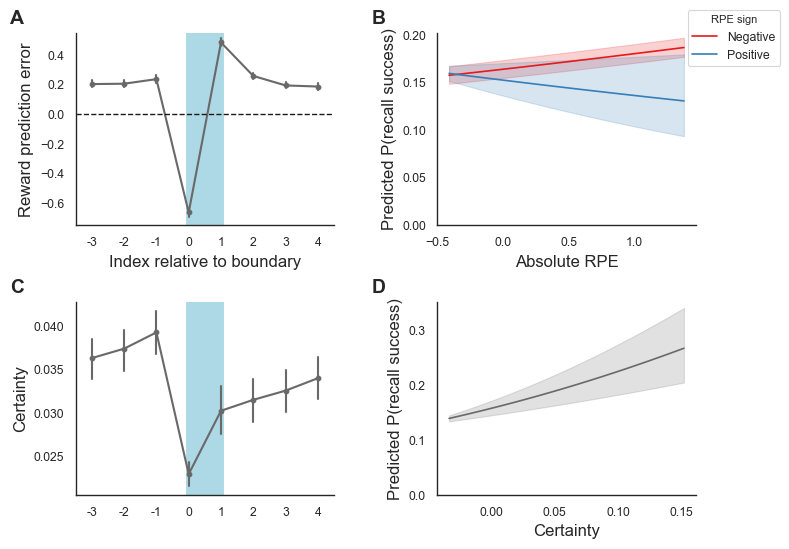

In [57]:
# Create a gridspec with width ratios [3, 2]
gs = gridspec.GridSpec(2, 2, wspace=0.4, hspace=0.4)

fig = plt.figure(figsize=(8, 6))
sns.despine()


# A
ax1 = plt.subplot(gs[1, 0])
rpe_df = (
    strat_df.groupby(["subid", "rel_subj_boundary"])["uncertainty"].mean().reset_index()
)
g = sns.pointplot(
    data=rpe_df,
    x="rel_subj_boundary",
    y="uncertainty",
    color="dimgrey",
    ax=ax1,
    order=range(-3, 5),
    errorbar="ci",
    scale=0.7,
)
g.set_ylabel("Certainty", fontsize=12)
g.set_xlabel("", fontsize=12)
g.add_patch(
    plt.Rectangle(
        (2.9, -0.62), 1.2, 1.24, facecolor="#ADD8E6", edgecolor=None, zorder=0
    )
)
# g.set_ylim(-0.62, 0.78)
sns.despine()

# B
# B
ax2 = plt.subplot(gs[1, 1])

# Create prediction data frame with a reference subject and word
certainty_range = np.linspace(
    log_reg_df["mean_cent_certainty"].min(),
    log_reg_df["mean_cent_certainty"].max(),
    100,
)
pred_df = pd.DataFrame(
    {
        "mean_cent_certainty": certainty_range,
        "mean_cent_abs_rpe": np.zeros_like(certainty_range),  # Hold at mean
        "val_rpe": np.ones_like(certainty_range),  # Hold at reference level
        "subid": [log_reg_df["subid"].iloc[0]]
        * len(certainty_range),  # Reference subject
        "word": [log_reg_df["word"].iloc[0]] * len(certainty_range),  # Reference word
    }
)

# Get fixed effects coefficients from model
fixed_effects = model2.coefs

# Calculate log odds and CIs
for ci in ["Estimate", "2.5_ci", "97.5_ci"]:
    # Calculate log odds
    log_odds = (
        fixed_effects[ci]["(Intercept)"]
        + fixed_effects[ci]["mean_cent_certainty"] * pred_df["mean_cent_certainty"]
    )

    # Convert to probabilities
    pred_df[f"prob_{ci}"] = 1 / (1 + np.exp(-log_odds))

# Plot predictions with confidence band
ax2.fill_between(
    pred_df["mean_cent_certainty"],
    pred_df["prob_2.5_ci"],
    pred_df["prob_97.5_ci"],
    alpha=0.2,
    # color=pal[2],
    color="dimgrey",
)
ax2.plot(pred_df["mean_cent_certainty"], pred_df["prob_Estimate"], color="dimgrey")

ax2.set_xlabel("Certainty", fontsize=12)
ax2.set_ylabel("Predicted P(recall success)", fontsize=12)
sns.despine()


# C RPE
ax3 = plt.subplot(gs[0, 0])
rpe_df = strat_df.groupby(["subid", "rel_subj_boundary"])["rpe"].mean().reset_index()
g = sns.pointplot(
    data=rpe_df,
    x="rel_subj_boundary",
    y="rpe",
    color="dimgrey",
    ax=ax3,
    order=range(-3, 5),
    errorbar="ci",
    scale=0.7,
)
ax3.set_ylabel("Reward prediction error", fontsize=12)
ax3.set_xlabel("Index relative to boundary", fontsize=12)
g.add_patch(
    plt.Rectangle(
        (2.9, -0.75), 1.2, 1.34, facecolor="#ADD8E6", edgecolor=None, zorder=0
    )
)
ax3.set_ylim(-0.75, 0.55)
ax3.axhline(0, color="k", linestyle="--", linewidth=1)

ax4 = plt.subplot(gs[0, 1])

# Create prediction data frames for positive and negative RPEs
rpe_range = np.linspace(
    log_reg_df["mean_cent_abs_rpe"].min(), log_reg_df["mean_cent_abs_rpe"].max(), 100
)

# For negative RPEs (val_rpe = -1)
pred_df_neg = pd.DataFrame(
    {
        "mean_cent_certainty": np.zeros_like(rpe_range),  # Hold at mean
        "mean_cent_abs_rpe": rpe_range,
        "val_rpe": [-1] * len(rpe_range),
        "subid": [log_reg_df["subid"].iloc[0]] * len(rpe_range),
        "word": [log_reg_df["word"].iloc[0]] * len(rpe_range),
    }
)

# For positive RPEs (val_rpe = 1)
pred_df_pos = pred_df_neg.copy()
pred_df_pos["val_rpe"] = 1

# Get fixed effects coefficients and CIs
fixed_effects = model2.coefs

# Calculate log odds and CIs for negative RPEs
for ci in ["Estimate", "2.5_ci", "97.5_ci"]:
    # Calculate log odds
    log_odds_neg = (
        fixed_effects[ci]["(Intercept)"]
        + fixed_effects[ci]["mean_cent_abs_rpe"] * pred_df_neg["mean_cent_abs_rpe"]
        + fixed_effects[ci]["val_rpe"] * pred_df_neg["val_rpe"]
        + fixed_effects[ci]["mean_cent_abs_rpe:val_rpe"]
        * pred_df_neg["mean_cent_abs_rpe"]
        * pred_df_neg["val_rpe"]
    )

    # Convert to probabilities
    pred_df_neg[f"prob_{ci}"] = 1 / (1 + np.exp(-log_odds_neg))

    # Calculate log odds for positive RPEs
    log_odds_pos = (
        fixed_effects[ci]["(Intercept)"]
        + fixed_effects[ci]["mean_cent_abs_rpe"] * pred_df_pos["mean_cent_abs_rpe"]
        + fixed_effects[ci]["val_rpe"] * pred_df_pos["val_rpe"]
        + fixed_effects[ci]["mean_cent_abs_rpe:val_rpe"]
        * pred_df_pos["mean_cent_abs_rpe"]
        * pred_df_pos["val_rpe"]
    )

    pred_df_pos[f"prob_{ci}"] = 1 / (1 + np.exp(-log_odds_pos))

# Plot predictions with confidence bands
# Negative RPEs
ax4.fill_between(
    pred_df_neg["mean_cent_abs_rpe"],
    pred_df_neg["prob_2.5_ci"],
    pred_df_neg["prob_97.5_ci"],
    alpha=0.2,
    color=pal[0],
)
ax4.plot(pred_df_neg["mean_cent_abs_rpe"], pred_df_neg["prob_Estimate"], color=pal[0])

# Positive RPEs
ax4.fill_between(
    pred_df_pos["mean_cent_abs_rpe"],
    pred_df_pos["prob_2.5_ci"],
    pred_df_pos["prob_97.5_ci"],
    alpha=0.2,
    color=pal[1],
)
ax4.plot(pred_df_pos["mean_cent_abs_rpe"], pred_df_pos["prob_Estimate"], color=pal[1])

ax4.set_xlabel("Absolute RPE", fontsize=12)
ax4.set_ylabel("Predicted P(recall success)", fontsize=12)
legend_handles = [
    mlines.Line2D([], [], color=pal[0], label="Negative"),
    mlines.Line2D([], [], color=pal[1], label="Positive"),
]

# Add custom legend to the plot
plt.legend(
    handles=legend_handles,
    title="RPE sign",
    bbox_to_anchor=(1.35, 1.15),
    title_fontsize="small",
)
sns.despine()
sub_fig_labels = [(ax1, "C"), (ax2, "D"), (ax3, "A"), (ax4, "B")]
for ax, label in sub_fig_labels:
    ax.text(
        -0.2,
        1.12,
        label,
        transform=ax.transAxes,
        fontsize=14,
        fontweight="bold",
        va="top",
        ha="right",
    )
ax2.set_ylim(0, ax2.get_ylim()[1])
ax4.set_ylim(0, ax4.get_ylim()[1])

fig.savefig("../../results/figs/replication/rl_fig.png", bbox_inches="tight", dpi=350)